In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import truvari

In [44]:
data = pd.read_csv("similarity_500.txt", sep='\t')

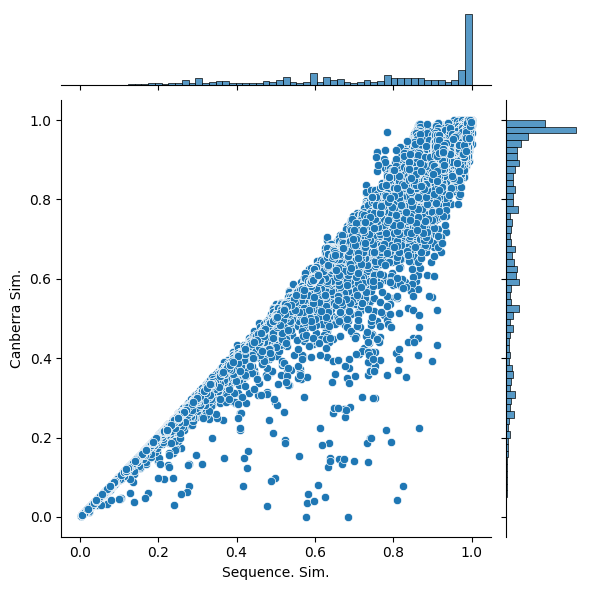

In [45]:
p = sb.jointplot(data=data, x="seqsim", y="cansim")
p.set_axis_labels(ylabel="Canberra Sim.", xlabel="Sequence. Sim.")
#p.set(title="Sequence Similarity vs Canberra Similarity", )

In [46]:
from scipy.stats import pearsonr
pearsonr(data['seqsim'], data['cansim'])

PearsonRResult(statistic=0.994528686764566, pvalue=0.0)

In [47]:
len(data), ((data['seqsim'] >= 0.95) & (data['szsim'] >= 0.95)).sum()

(141680, 41152)

Of these nearby insertion pairs, 41,152 (29%) have a size and sequence similarity above 95%, which included 30,641 pairs occurring at the exact same position. From these ≥95% similar insertion pairs, 37,918 (92%) also had a Canberra similarity above 95%. Therefore, many neighboring SVs are highly similar and the Canberra similarity metric is able to differentiate them.

In [48]:
tot_pairs = len(data)
highsim_pairs = data[(data['seqsim'] >= 0.95) & (data['szsim'] >= 0.95)]
tot_pairs, len(highsim_pairs), highsim_pairs['same_start'].sum(), (highsim_pairs['cansim'] >= 0.95).sum()

(141680, 41152, 30641, 37918)

[Text(0, 0.5, 'Similarity')]

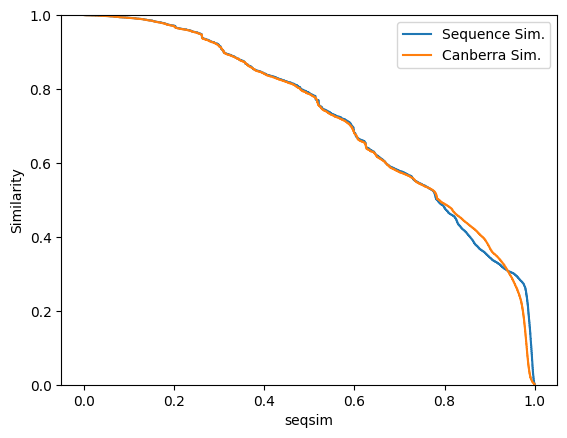

In [49]:
sb.ecdfplot(data=data, x="seqsim", label="Sequence Sim.", complementary=True)
p = sb.ecdfplot(data=data, x="cansim", label="Canberra Sim.", complementary=True)
plt.legend()
p.set(ylabel="Similarity")